# Pneumonia Detection using Chest X-Rays
Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

Computer vision is an interdisciplinary scientific field that deals with how computers can gain a high-level understanding from digital images or videos. From the perspective of engineering, it seeks to understand and automate tasks that the human visual system can do. We can use Computer Vision to determine whether a person is affected by pneumonia or not.

The dataset for this project is available at https://data.mendeley.com/datasets/rscbjbr9sj/3. Do check if it is the latest version. As of writing this notebook, the data has version 3 and published date of June 1, 2018. The download link for the dataset is https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/810b2ce2-11c3-4424-996e-3bef36600907/file_downloaded. Its size is about 8GB.  After unzipping, there should be a folder names 'CellData'. This contains a subfolder names 'chest_xray'. That is the relevant subfolder to this notebook. We will be doing image classification based on chest x-rays. The notebook assumes the presence of this 'chest_xray' folder in the home folder.

In [52]:
# Usual Imports
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import seaborn as sns

# Pytorch Image Imports
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Neural Network Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report

# Image Processing Inputs
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid

## Preprocessing

In [2]:
# Get paths of all images in training and test datasets
root_dir = 'chest_xray'
train_dir = os.path.join(root_dir, 'train')
test_dir =  os.path.join(root_dir, 'test')
img_classes = ['NORMAL', 'PNEUMONIA']
img_paths = []

for img_dir in [train_dir, test_dir]:
    for img_class in img_classes:
        temp_dir = os.path.join(img_dir, img_class)
        img_paths.append([os.path.join(temp_dir,f) for f in os.listdir(temp_dir)])
    
len(img_paths[0]), len(img_paths[1]), len(img_paths[2]), len(img_paths[3]),

(1349, 3883, 234, 390)

In [3]:
train_img_paths = img_paths[0] + img_paths[1]
print(train_img_paths[:5])

test_img_paths = img_paths[2] + img_paths[3]
print(test_img_paths[-5:])

['chest_xray\\train\\NORMAL\\NORMAL-1003233-0001.jpeg', 'chest_xray\\train\\NORMAL\\NORMAL-1012843-0001.jpeg', 'chest_xray\\train\\NORMAL\\NORMAL-1014768-0001.jpeg', 'chest_xray\\train\\NORMAL\\NORMAL-1023731-0001.jpeg', 'chest_xray\\train\\NORMAL\\NORMAL-1029510-0001.jpeg']
['chest_xray\\test\\PNEUMONIA\\VIRUS-9584831-0001.jpeg', 'chest_xray\\test\\PNEUMONIA\\VIRUS-9671740-0001.jpeg', 'chest_xray\\test\\PNEUMONIA\\VIRUS-9783315-0001.jpeg', 'chest_xray\\test\\PNEUMONIA\\VIRUS-9890836-0001.jpeg', 'chest_xray\\test\\PNEUMONIA\\VIRUS-9968655-0001.jpeg']


We can see that the files are named as 'Label-Patient_num-Image_num'. The labels are 'NORMAL', 'VIRUS', 'BACTERIA'. Thus, we have data about whether the pneumonia detected during the x-ray is bacterial or viral. This forms a classification problem with 3 labels. We can predict whether a chest x-ray shows normal lungs or infected ones, and specify whether the infection is bacterial or viral.

In [4]:
print('Train:',len(train_img_paths))
print('Test:',len(test_img_paths))

Train: 5232
Test: 624


Thus, we have 5232 training images and 624 testing images. We can write a simple function to extract labels from the image file paths.

In [5]:
def get_labels(img_paths):
    labels = []
    for i in img_paths:
        labels.append(i.split('\\')[-1].split('-')[0])
    return labels

In [6]:
# Shuffle images to randomize order of labels
random.shuffle(train_img_paths)
random.shuffle(test_img_paths)

train_labels = get_labels(train_img_paths)
test_labels = get_labels(test_img_paths)

train_labels[:5]

['BACTERIA', 'VIRUS', 'BACTERIA', 'VIRUS', 'VIRUS']

Let us check if there is any imbalance in data

In [7]:
print('Train:',Counter(train_labels))
print('Test:',Counter(test_labels))

Train: Counter({'BACTERIA': 2538, 'NORMAL': 1349, 'VIRUS': 1345})
Test: Counter({'BACTERIA': 242, 'NORMAL': 234, 'VIRUS': 148})


While there are almost twice as many BACTERIA cases in training data as NORMAL and VIRUS ones, the data is fairly balanced. Next, we can enumerate the image labels and write dictionaries to get one from the other.

In [8]:
img_classes = ['NORMAL','BACTERIA','VIRUS']
labels2keys = {value: key for (key,value) in enumerate(img_classes)}
keys2labels = {key: value for (key,value) in enumerate(img_classes)}

numeric_train_labels = [labels2keys[label] for label in train_labels]
numeric_test_labels = [labels2keys[label] for label in test_labels]

numeric_train_labels[:5]

[1, 2, 1, 2, 2]

In order to reduce overfitting of our Convolutional Neural Network (CNN), we can augment the images in different ways. This helps the network to learn general features and be robust. Albumentations (https://albumentations.ai/) is a great library for this purpose.

First we create Albumentations Dataset class

In [9]:
class AlbumentationsDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

Next, we create an image augmentation pipeline by creating a Compose class instance. As an argument to the Compose class, we need to pass a list of augmentations we want to apply. A call to Compose will return a transform function that will perform image augmentation.

In [10]:
alb_transform = A.Compose([
    # Resize the image to 256*256
    A.Resize(256, 256),
    # Select a random crop of size width*height
    A.RandomCrop(width=224, height=224),
    # Flip the image horizontally with probability p
    A.HorizontalFlip(p=0.5),
    # Change brightness and contrast of image with probability p
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.RandomGamma(p=0.3),
    A.MedianBlur(blur_limit=3, p=0.3),
    # Convert to torch tensor
    ToTensorV2()
])

In [11]:
train_ds = AlbumentationsDataset(file_paths=train_img_paths, labels=numeric_train_labels, transform=alb_transform)
test_ds = AlbumentationsDataset(file_paths=test_img_paths, labels=numeric_test_labels, transform=alb_transform)

Now, we can load this data into a DataLoader. It takes a data set and returns batches of images and corresponding labels. Before we do so, we should split the train dataset into 2 parts: train, val.

In [12]:
train_ds, val_ds = random_split(train_ds, [4500, 732])
print('Train:',len(train_ds), 'Val:', len(val_ds))

Train: 4500 Val: 732


In [13]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=0)

We can create a helper function to visualize an image or a single batch of images.

In [14]:
def show_images(images, labels):
    fig = plt.figure()
    fig.set_size_inches(20, 12)
    grid = ImageGrid(fig, 111, nrows_ncols=(4,8), axes_pad=(0.1,0.3), share_all=True)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    for ax, im, lb in zip(grid, images, labels):
        # Iterating over the grid returns the Axes.
        ax.imshow(im.permute(1,2,0), cmap='gray')
        ax.set_title(lb)
    plt.show()

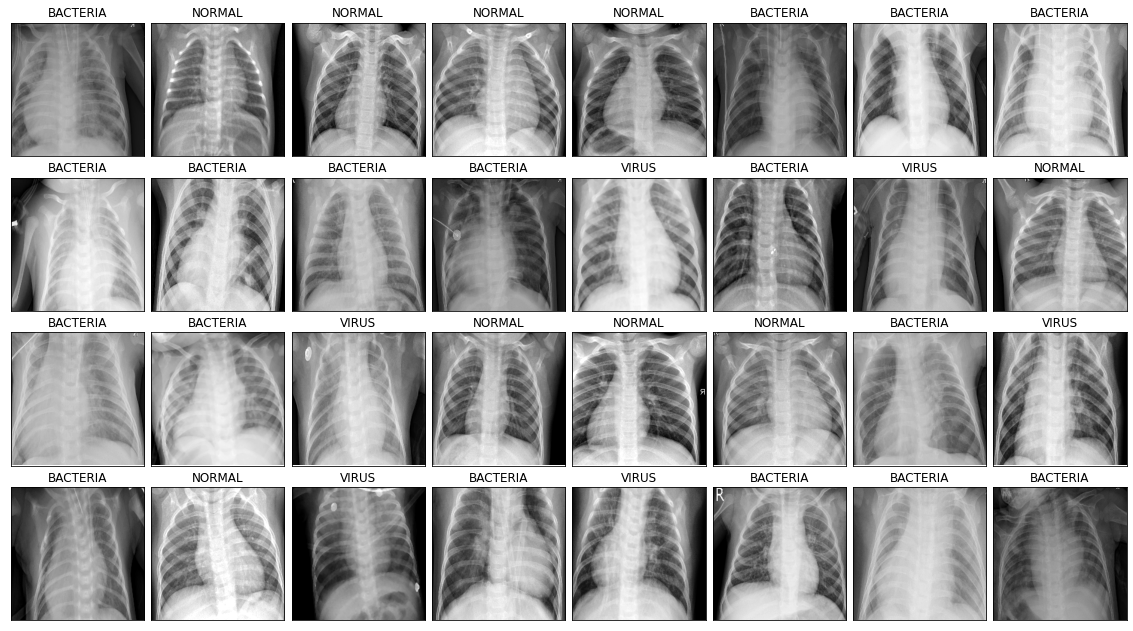

In [15]:
images, labels = next(iter(train_dl))
show_images(images, [keys2labels[label] for label in labels.tolist()])

## Building CNN

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.dropout = nn.Dropout(p=0.1)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256*7*7, 128, bias=True)
        self.fc2 = nn.Linear(128, 3, bias=True)
        
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(self.bn1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(self.bn2(self.dropout(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(self.bn3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(self.bn4(self.dropout(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(self.bn5(self.dropout(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

In [24]:
summary(model,(1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
           Dropout-5         [-1, 64, 112, 112]               0
       BatchNorm2d-6         [-1, 64, 112, 112]             128
         MaxPool2d-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 128, 28, 28]          73,856
          Dropout-12          [-1, 128, 28, 28]               0
      BatchNorm2d-13          [-1, 128, 28, 28]             256
        MaxPool2d-14          [-1, 128,

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
learning_rate_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

## Training and Validating

In [30]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=100):
    min_val_loss = np.inf
    for epoch in range(num_epochs):

        train_loss = 0.0
        model.train()
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss = loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1} \t\t \
                Training Loss: {train_loss / len(train_dl)} \t\t \
                Validation Loss: {val_loss / len(val_dl)}')
        if min_val_loss > val_loss:
            print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
            min_val_loss = val_loss
            
            torch.save(model.state_dict(), 'customCNN.pth')

    print('Finished Training')
    
    return model

In [31]:
model = train_model(model, criterion, optimizer, learning_rate_scheduler, num_epochs=25)

Epoch 1 		                 Training Loss: 0.40578496963419813 		                 Validation Loss: 0.6432891617650571
Validation Loss Decreased(inf--->14.795651) 	 Saving The Model
Epoch 2 		                 Training Loss: 0.40984719167364403 		                 Validation Loss: 0.47455028347347095
Validation Loss Decreased(14.795651--->10.914657) 	 Saving The Model
Epoch 3 		                 Training Loss: 0.4008902813314546 		                 Validation Loss: 0.5187236692594446
Epoch 4 		                 Training Loss: 0.3985392329752023 		                 Validation Loss: 0.5429370869760928
Epoch 5 		                 Training Loss: 0.3948647194931693 		                 Validation Loss: 0.6584853504015051
Epoch 6 		                 Training Loss: 0.384248231478194 		                 Validation Loss: 0.35251263950182044
Validation Loss Decreased(10.914657--->8.107791) 	 Saving The Model
Epoch 7 		                 Training Loss: 0.3893194964802857 		                 Validation Loss: 0.51

We see that our model has overfit, since the validation reduced and then went up. Therefore, we can get weights corresponding to the least loss.

In [32]:
model.load_state_dict(torch.load('customCNN.pth'))

<All keys matched successfully>

In [33]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 624 test images: {100 * correct // total} %')

Accuracy of the network on the 624 test images: 84 %


We got an accuracy of 84%. Let us see how well the classifications were handled. In such a medical dataset, we would like to reduce the classifications where the model predicted a normal lung condition when it was in fact infected. This can be understood from confusion matrix.

In [40]:
y_pred = []
y_true = []

for inputs, labels in test_dl:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs.float())
    outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
    y_pred.extend(outputs)
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

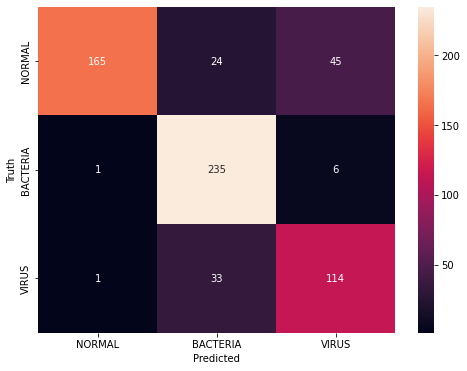

In [51]:
def visualize_cfmatrix(cf_matrix, classes):
    plt.figure(figsize=(8,6))
    sns.heatmap(cf_matrix, annot=True, xticklabels=classes, yticklabels=classes, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

cf_matrix = confusion_matrix(y_true, y_pred)
visualize_cfmatrix(cf_matrix, img_classes)

In [63]:
print(classification_report(y_true, y_pred, target_names=img_classes, digits=3))

              precision    recall  f1-score   support

      NORMAL      0.988     0.705     0.823       234
    BACTERIA      0.805     0.971     0.880       242
       VIRUS      0.691     0.770     0.728       148

    accuracy                          0.824       624
   macro avg      0.828     0.815     0.811       624
weighted avg      0.846     0.824     0.823       624



We see that the model had some problem identifying between bacterial and viral infection, but it certainly predicted an infection almost all the time. To make this more clear, we can compare the recall for pairs of labels.

NORMAL vs BACTERIA
We see that there were 235 predictions of bacterial infection that were indeed true, while there was 1 prediction of normal lungs when they were in fact infected with bacteria. Thus, we have 235 true positives and 1 false negative. This gives us recall = 235/236 = 99.57%.

NORMAL vs VIRUS
We see that there were 114 predictions of viral infection that were indeed true, while again there was just 1 prediction of normal lungs when they were in fact infected with virus. Thus, we have 114 true positives and 1 false negative, giving us recall = 114/115 = 99.13%.

Thus, we have exceptionally good recall for this model, which is a good thing in a medical dataset like this.